The Antecedent Precipitation Index (API) is a simple hydrological model used to approximate soil moisture content by retrospectively analyzing precipitation events. The API integrates precipitation data over a defined period, typically using an exponential decay function to weigh recent rainfall events more heavily than older rainfall events. In hydrological modeling, the API is widely used in runoff models since it quantifies the antecedent wetness condition of a catchment. The formula for the API model is:

$$API_{t} = \gamma \; API_{t-1} + P_t $$
$$ \gamma = M + A \ cos\Bigg( \frac{2 \ \pi \ doy}{P} \Bigg) $$


$API_t$: Soil water content at time $t$ (today)<br>
$API_{t-1}$: Soil water content at time $t-1$ (yesterday)<br>
$P_t$: Precipitation at time $t$ (today)<br>
$\gamma$: Loss coefficient that ranges between 0 and 1. This coefficient accounts for the combined losses due to runoff, drainage, evaporation, and transpiration. To reflect  seasonal variations in atmospheric demand, the loss coefficient is modeled as a function of the day of the year.<br>
$doy$ Day of the year since January 1<br>
$P$ Period, in this case 365 days<br>
$M$ is the annnual mean value of the loss coefficient<br>
$A$ is the annual amplitude of the loss coefficient<br>


In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [31]:
# Load data from .CSV file
df = pd.read_csv('../datasets/kings_creek_2022_2023_daily.csv',
                 parse_dates=['datetime'])
df.head(3)


,datetime,pressure,tmin,tmax,tavg,rmin,rmax,prcp,srad,wspd,wdir,vpd,vwc_5cm,vwc_20cm,vwc_40cm,soiltemp_5cm,soiltemp_20cm,soiltemp_40cm,battv,discharge
0,2022-01-01,96.838,-14.8,-4.4,-9.6,78.475,98.012,0.25,2.098,5.483,0.969,0.028,0.257,0.307,0.359,2.996,5.392,7.425,8714.833,0.0
1,2022-01-02,97.995,-20.4,-7.2,-13.8,50.543,84.936,0.25,9.756,2.216,2.023,0.072,0.256,0.307,0.358,2.562,4.250,6.692,8890.042,0.0
2,2022-01-03,97.844,-9.4,8.8,-0.3,40.622,82.662,0.50,9.681,2.749,5.667,0.262,0.255,0.307,0.358,2.454,3.917,6.208,8924.833,0.0


In [32]:
# Check if we have any missing values in our precipitation time series
df['prcp'].isna().sum()

0

In [33]:
# Add day of the year column
df.insert(1, 'doy', df['datetime'].dt.dayofyear)

# Add year column, to easily divide the dataset into calibration and validation sets
df.insert(2, 'year', df['datetime'].dt.year)

# Print a few rows to check our new added column
df.head(3)


,datetime,doy,year,pressure,tmin,tmax,tavg,rmin,rmax,prcp,...,wdir,vpd,vwc_5cm,vwc_20cm,vwc_40cm,soiltemp_5cm,soiltemp_20cm,soiltemp_40cm,battv,discharge
0,2022-01-01,1,2022,96.838,-14.8,-4.4,-9.6,78.475,98.012,0.25,...,0.969,0.028,0.257,0.307,0.359,2.996,5.392,7.425,8714.833,0.0
1,2022-01-02,2,2022,97.995,-20.4,-7.2,-13.8,50.543,84.936,0.25,...,2.023,0.072,0.256,0.307,0.358,2.562,4.250,6.692,8890.042,0.0
2,2022-01-03,3,2022,97.844,-9.4,8.8,-0.3,40.622,82.662,0.50,...,5.667,0.262,0.255,0.307,0.358,2.454,3.917,6.208,8924.833,0.0


In [114]:
# Compute soil water storage in top 30 cm from  volmetric water content.
df['storage'] = df['vwc_5cm']*100 + df['vwc_20cm']*200 # Layer thickness in mm


In [115]:
## Divide dataset into calibration and validation

# Calibration dataset
idx_cal = df['year'] == 2022
df_cal = df.loc[idx_cal,:].reset_index(drop=True)

# Validation dataset
idx_val = df['year'] != 2022
df_val = df.loc[idx_val,:].reset_index(drop=True)


## Define API model



In [116]:
# Function for the API model

def api_model(inputs,M=0.97,A=0.03,S_ini=100):
    """
    Antecedent Precipitation Index model for simualting soil wetness 
    from precipitation data.
    """   

    P = inputs[0]
    doy = inputs[1]
    
    # Create lists of output variables 
    api = np.full_like(P, np.nan) 
    api[0] = S_ini # Populate with initial moisture
    
    # Compute loss coefficient for each DOY
    loss = M + A * np.cos(2*np.pi*doy/365)
    
    # Iterate over each input value
    for t in range(1,len(P)):
        
        # Compute API
        api[t] = api[t-1]*loss[t] + P[t]
    
    return api
    

## Guess API parameter values

Trying or guessing different parameter values is usually a great exercise to learn how the model responds and test our intuition. Of course for any research application we need something more accurate than a mere guess. Later we will optimize the model to find the best loss coefficient.

In [117]:
# Plot model with guessed values
inputs = [df_cal['prcp'],df_cal['doy']]
api_guessed = api_model(inputs, M=0.95, A=0.05, S_ini=120)


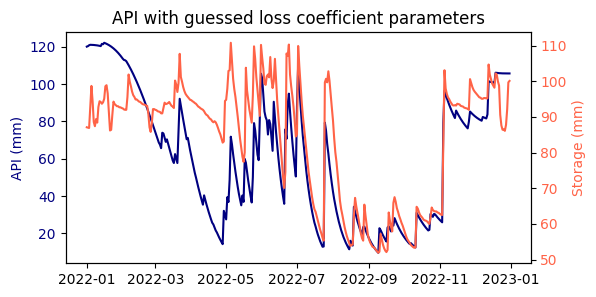

In [118]:
# Create figure
plt.figure(figsize=(6,3))

plt.title('API with guessed loss coefficient parameters')
plt.plot(df_cal['datetime'], api_guessed, color='navy', label='API')
plt.ylabel('API (mm)', color='navy')
plt.yticks(color='navy')
plt.twinx()
plt.plot(df_cal['datetime'], df_cal['storage'], color='tomato', label='Storage in top 50 cm')
plt.ylabel('Storage (mm)', color='tomato')
plt.yticks(color='tomato')

plt.show()


## API model calibration

To optimize the model we will use the soil water storage in the calibration dataset.

In [119]:
# Optimize parameters
inputs_cal = [df_cal['prcp'],df_cal['doy']]
par_opt_cal, par_cov_cal = curve_fit(api_model, inputs_cal, df_cal['storage'],
                                     p0=[0.95,0.05,100])
print('Optimized loss coefficient is:', round(par_opt[0],2))


Optimized loss coefficient is: 0.99


In [120]:
# Compute API using optimized parameters
api_cal = api_model(inputs_cal, *par_opt_cal)


In [121]:
# Mean absolute error of the calibration dataset
MAE = np.mean(np.abs(df_cal['storage'] - api_cal))
print('MAE calibration =', round(MAE,1),'mm')

MAE calibration = 17.1 mm


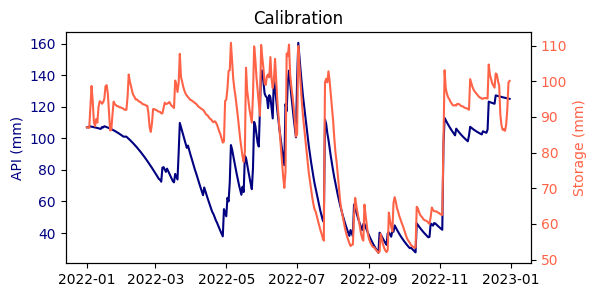

In [122]:
# Create figure
plt.figure(figsize=(6,3))

plt.title('Calibration')
plt.plot(df_cal['datetime'], api_cal, color='navy')
plt.ylabel('API (mm)', color='navy')
plt.yticks(color='navy')
plt.twinx()
plt.plot(df_cal['datetime'], df_cal['storage'], color='tomato')
plt.ylabel('Storage (mm)', color='tomato')
plt.yticks(color='tomato')

plt.show()

## Validate model

For this part we will use the optimized parameters using the calibration dataset, but the inputs are obtained from the validation dataset. In other words, we want to see how well  the model predicts soil moisture given a new set of inputs.

In [123]:
inputs_val = [df_val['prcp'],df_val['doy']]
api_val = api_model(inputs_val, *par_opt_cal)

# Mean absolute error of the validation dataset
MAE = np.mean(np.abs(df_val['storage'] - api_val))
print('MAE validation =', round(MAE,1),'mm')

MAE validation = 25.8 mm


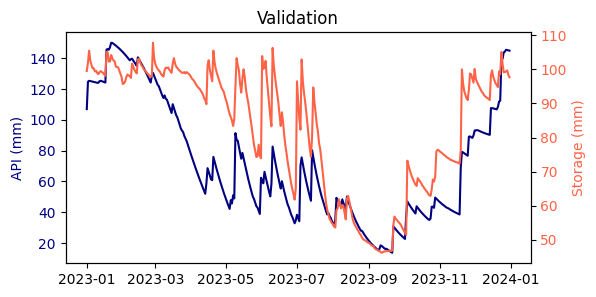

In [124]:
# Create figure
plt.figure(figsize=(6,3))

plt.title('Validation')
plt.plot(df_val['datetime'], api_val, color='navy')
plt.ylabel('API (mm)', color='navy')
plt.yticks(color='navy')
plt.twinx()
plt.plot(df_val['datetime'], df_val['storage'], color='tomato')
plt.ylabel('Storage (mm)', color='tomato')
plt.yticks(color='tomato')

plt.show()

## API for entire period and compare to streamflow

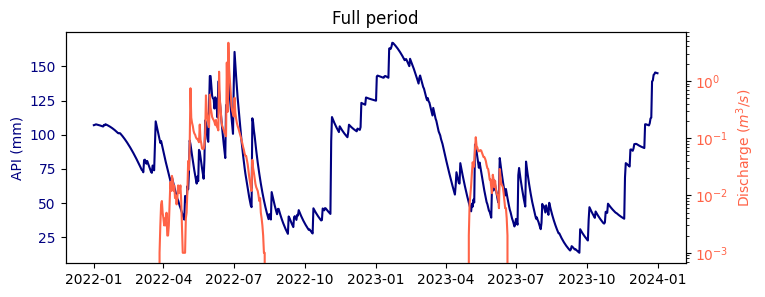

In [126]:
# Predict for full period using calibrated parameters
inputs = [df['prcp'],df['doy']]
api = api_model(inputs, *par_opt_cal)

# Figure
plt.figure(figsize=(8,3))
plt.title('Full period')
plt.plot(df['datetime'], api, color='navy')
plt.ylabel('API (mm)', color='navy')
plt.yticks(color='navy')
plt.twinx()
plt.plot(df['datetime'], df['discharge'], color='tomato')
plt.yscale('log')
plt.ylabel('Discharge ($m^3/s$)', color='tomato')
plt.yticks(color='tomato')
plt.show()

## Comments

- The model is fairly good considering that we are only using rainfall and couple parameters to to model a complex variable such as soil moisture.

- The main drawback of this model is that the upper limit of soil water storage remains unbounded

- Why do you think that sometimes when the soil wetness (high API values) is high, there is not streamflow discharge in this particular watershed dominated by a tallgrass prairie?


## Practice

- Create a plot of the residuals between the observed and predicted soil water storage using the optimized parameters. Can you see any trends?

- Modify the model so that it cannot exceed the maximum soil water storage, assuming a soil porosity of 50%.

## References

Saxton, K.E. and Lenz, A.T., 1967. Antecedent retention indexes predict soil moisture. Journal of the Hydraulics Division.